# word2vecの分類　（dbscan Scikit-learn）

Scikit-learnを使用してクラスター分類を行う。
dbscanを調べる。

In [1]:
# 使用ライブラリのインストール

!pip install -U scikit-learn

!pip install --upgrade gensim

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from gensim.models import KeyedVectors
from sklearn.cluster import DBSCAN
import numpy as np

def dbscan_cluster_words(model_path, eps, min_samples):
    # Word2Vecモデルの読み込み
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # 全単語のベクトルを取得
    word_vectors = model.vectors

    # DBSCANクラスタリングの実行
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_indices = dbscan.fit_predict(word_vectors)

    # 単語とクラスタの対応を表示
    word_cluster_map = {word: cluster_indices[i] for i, word in enumerate(model.index_to_key)}

    # 結果を表示 (例: 最初の10単語)
    for word, cluster in list(word_cluster_map.items())[:10]:
        print(f"Word: {word}, Cluster: {cluster}")

    return word_vectors, cluster_indices

/Users/mfujimak/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
from gensim.models import KeyedVectors
from sklearn.cluster import DBSCAN
import numpy as np

def dbscan_cluster_words_in_batches(model_path, batch_size, eps, min_samples):
    # Word2Vecモデルの読み込み
    model = KeyedVectors.load_word2vec_format(model_path, binary=False)

    # 全単語のベクトルを取得
    word_vectors = model.vectors
    num_words = len(word_vectors)

    # バッチ処理を準備
    word_cluster_map = {}
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    for start_idx in range(0, num_words, batch_size):
        # バッチ分割
        end_idx = min(start_idx + batch_size, num_words)
        batch_vectors = word_vectors[start_idx:end_idx]

        # DBSCANクラスタリングの実行
        cluster_indices = dbscan.fit_predict(batch_vectors)

        # バッチごとに単語とクラスタの対応を保存
        for i, word in enumerate(model.index_to_key[start_idx:end_idx]):
            word_cluster_map[word] = cluster_indices[i]

    # 結果を表示 (例: 最初の10単語)
    for word, cluster in list(word_cluster_map.items())[:10]:
        print(f"Word: {word}, Cluster: {cluster}")

    return word_vectors, cluster_indices


In [5]:

model_path = '../data/japanese_word2vec_vectors.vec'
batch_size = 1000
eps = 0.5
min_samples = 5
word_vectors, cluster_indices = dbscan_cluster_words_in_batches(model_path, batch_size)

Word: の, Cluster: -1
Word: 、, Cluster: -1
Word: 。, Cluster: -1
Word: に, Cluster: -1
Word: は, Cluster: -1
Word: を, Cluster: -1
Word: た, Cluster: -1
Word: が, Cluster: -1
Word: で, Cluster: -1
Word: て, Cluster: -1


In [7]:
import logging
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import resample

# ログ設定
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def plot_cluster_word_counts(cluster_indices):
    logging.info("Calculating the number of words per cluster...")
    unique, counts = np.unique(cluster_indices, return_counts=True)
    cluster_counts = dict(zip(unique, counts))

    logging.info("Plotting the number of words per cluster...")
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
    plt.title('Number of Words per Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Number of Words')
    plt.show()

def plot_cluster_centers_pca(word_vectors, kmeans):
    logging.info("Performing PCA on word vectors...")
    pca = PCA(n_components=2)
    word_vectors_pca = pca.fit_transform(word_vectors)
    cluster_centers_pca = pca.transform(kmeans.cluster_centers_)

    logging.info("Plotting word vectors and cluster centers...")
    plt.figure(figsize=(10, 8))
    plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], c=cluster_indices, cmap='viridis', alpha=0.5, s=10)
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='x', s=100, label='Cluster Centers')
    plt.title('Word Vectors and Cluster Centers (PCA)')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

def plot_silhouette_analysis(word_vectors, cluster_indices, num_clusters):
    logging.info("Calculating silhouette score...")
    sampled_word_vectors, sampled_cluster_indices = resample(word_vectors, cluster_indices, n_samples=int(0.01*len(word_vectors)), random_state=42)
    silhouette_avg = silhouette_score(sampled_word_vectors, sampled_cluster_indices)
    logging.info(f"Silhouette Score: {silhouette_avg:.3f}")

    logging.info("Plotting silhouette scores for each cluster...")
    sample_silhouette_values = silhouette_samples(sampled_word_vectors, sampled_cluster_indices)
    y_lower = 10

    plt.figure(figsize=(10, 8))

    # クラスターごとのサンプル数が大きい場合に進行状況を表示
    for i in tqdm(range(num_clusters), desc="Clusters processed"):
        ith_cluster_silhouette_values = sample_silhouette_values[sampled_cluster_indices == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = plt.cm.nipy_spectral(float(i) / num_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    plt.title("Silhouette Plot for Various Clusters")
    plt.xlabel("Silhouette Coefficient Values")
    plt.ylabel("Cluster")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()

2024-09-15 23:59:37,278 - INFO - Calculating the number of words per cluster...
2024-09-15 23:59:37,280 - INFO - Plotting the number of words per cluster...
2024-09-15 23:59:37,352 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/var/folders/2x/p5h03dq11m7b230v42t51spw0000gn/T/ipykernel_32314/3546456425.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette="viridis")
2024-09-15 23:59:37,358 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


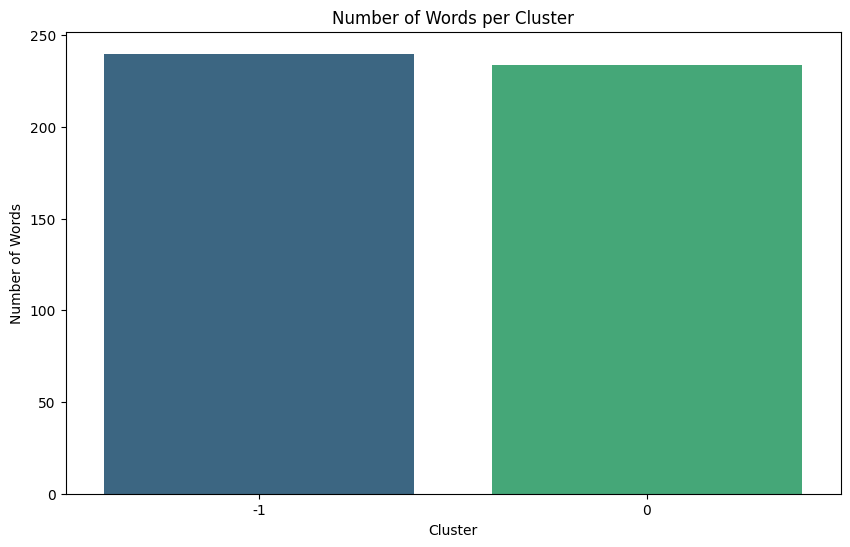

In [8]:
plot_cluster_word_counts(cluster_indices)